Import packages!

In [1]:
import numpy as np

Read the splice data

In [2]:
fname = 'splice.data'
with open(fname) as f:
    content = f.readlines()
content = [x.strip().split(',') for x in content]
for l in content:
    for i in range(len(l)):
        l[i] = l[i].strip()
raw_data = np.array(content)

In [3]:
# Given one 'row' of data, constructs an input and output out of it
def getInstance(row):
    one_hot = np.zeros((1, 3))
    label = row[0]
    if label == 'EI':
        one_hot[0][0] = 1
    elif label == 'IE':
        one_hot[0][1] = 1
    else:
        one_hot[0][2] = 1
    orth = np.zeros((len(row[2]), 4))
    for i in range(len(row[2])):
        c = row[2][i]
        if c == 'A':
            orth[i][0] = 1
        elif c == 'C':
            orth[i][1] = 1
        elif c == 'G':
            orth[i][2] = 1
        elif c == 'T':
            orth[i][3] = 1
        elif c == 'D':
            orth[i][0] = 1/3.
            orth[i][2] = 1/3.
            orth[i][3] = 1/3.
        elif c == 'N':
            orth[i][0] = 1/4.
            orth[i][1] = 1/4.
            orth[i][2] = 1/4.
            orth[i][3] = 1/4.
        elif c == 'S':
            orth[i][1] = 1/2.
            orth[i][2] = 1/2.
        elif c == 'R':
            orth[i][0] = 1/2.
            orth[i][2] = 1/2.
    return orth, one_hot

In [4]:
x = []
y = []
for i in range(raw_data.shape[0]):
    xi, yi = getInstance(raw_data[i])
    x.append(xi)
    y.append(yi)
x = np.array(x)
y = np.array(y)

# Shuffle dataset since it's unevenly distributed
shuffle_index = np.random.permutation(len(x))
x = x[shuffle_index]
y = y[shuffle_index]

# Conv1D expects channels first
x = np.swapaxes(x, 1, 2)
print (x.shape, y.shape)

(3190, 4, 60) (3190, 1, 3)


Construct a classification model

In [304]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv1D, Dropout, MaxPooling1D
from keras.callbacks import TensorBoard
from keras import backend as K

In [305]:
from keras.backend import clear_session
clear_session()
K.set_learning_phase(True)

In [334]:
model = Sequential()
model.add(Conv1D(8, 3, input_shape=(None, 60), padding='same', name='conv1'))
model.add(Activation('relu'))
model.add(MaxPooling1D())
model.add(Conv1D(16, 3, padding='same', name='conv2'))
model.add(Activation('relu'))
model.add(MaxPooling1D())
model.add(Dense(3, name='fc1'))
model.add(Dropout(0.5))
model.add(Activation('softmax'))

In [335]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [336]:
callbacks = []
#callbacks.append(TensorBoard(write_graph=False, histogram_freq=1, write_grads=False, write_images=False))

model.fit(x, y, epochs=30, batch_size=32, validation_split=0.1, shuffle=True, callbacks=callbacks)
K.set_learning_phase(False)

Train on 2871 samples, validate on 319 samples
Epoch 1/30
2871/2871 [==============================] - 4s 1ms/step - loss: 0.9931 - acc: 0.5131 - val_loss: 0.8256 - val_acc: 0.6583
Epoch 2/30
2871/2871 [==============================] - 1s 206us/step - loss: 0.6208 - acc: 0.7844 - val_loss: 0.4016 - val_acc: 0.8871
Epoch 3/30
2871/2871 [==============================] - 1s 176us/step - loss: 0.3112 - acc: 0.9094 - val_loss: 0.2267 - val_acc: 0.9310
Epoch 4/30
2871/2871 [==============================] - 0s 163us/step - loss: 0.1968 - acc: 0.9446 - val_loss: 0.1753 - val_acc: 0.9373
Epoch 5/30
2871/2871 [==============================] - 0s 161us/step - loss: 0.1477 - acc: 0.9606 - val_loss: 0.1473 - val_acc: 0.9530
Epoch 6/30
2871/2871 [==============================] - 0s 150us/step - loss: 0.1193 - acc: 0.9666 - val_loss: 0.1414 - val_acc: 0.9498
Epoch 7/30
2871/2871 [==============================] - 0s 139us/step - loss: 0.0999 - acc: 0.9725 - val_loss: 0.1373 - val_acc: 0.9498
Epo

In [352]:
import matplotlib.pyplot as plt

def visualizeLayer(layer_name, filter_index):
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer_output = layer_dict[layer_name].output
    print (layer_output)
    loss = K.mean(layer_output[:, :, filter_index])
    #loss = K.mean(model.output[:, :, filter_index])
    input_img = model.input
    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    #grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])
    # we start from a gray image with some noise
    input_img_data = np.zeros((1, 4, 60))
    input_img_data[:] = 0.25
    # run gradient ascent for 20 steps
    step = 1
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
        #print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            # break
            pass
    input_img_data[0] /= np.linalg.norm(input_img_data[0], 1, axis=0)
    input_img_data = np.clip(input_img_data, 0, 1)
    plt.imshow(input_img_data[0], cmap='viridis')
    plt.show()

Tensor("activation_15/truediv:0", shape=(?, ?, 3), dtype=float32)
Tensor("conv2_4/add:0", shape=(?, ?, 16), dtype=float32)


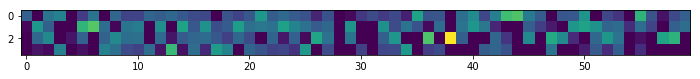

In [356]:
print (model.output)
visualizeLayer('conv2', 2)

In [329]:
index = 0
print (model.output.shape)
loss = K.mean(model.output[:, :, np.argmax(y[index])])
input_img = model.input
grads = K.gradients(loss, input_img)[0]
print (grads)
iterate = K.function([input_img], [loss, grads])
input_img_data = np.zeros((1, 4, 60))
input_img_data[0,:] = x[index]
loss_value, grads_value = iterate([input_img_data])
print (grads_value)

(?, ?, 3)
Tensor("gradients_9/conv1_3/convolution/ExpandDims_grad/Reshape:0", shape=(?, ?, 60), dtype=float32)
[[[ -3.38530335e-05  -1.09222510e-05   2.17180641e-05  -2.13855019e-05
    -4.87073248e-06  -4.81878233e-05   2.93413032e-05   1.91459767e-05
    -4.82541182e-05  -2.63182301e-05  -4.55569534e-07   1.26191480e-05
    -3.03119068e-05  -2.52373720e-05  -5.45610055e-05  -1.24207745e-05
    -4.88756705e-05  -6.36362602e-05  -1.84765850e-05  -4.03819504e-05
    -7.96740351e-05  -6.88788350e-05  -5.47513300e-05   7.14944508e-06
    -4.08492451e-05  -1.94330714e-05   2.39002311e-05  -1.03636601e-04
     2.21989379e-04  -1.05729683e-04  -3.31019692e-05  -2.43304239e-05
     1.62793076e-05   6.87954744e-05  -6.57456403e-05  -1.86824946e-05
     1.54897862e-05  -1.74521520e-05  -4.96585972e-06  -2.55416380e-05
    -8.39160748e-06  -2.17099023e-05   1.70015792e-05  -7.65475033e-06
    -1.63778132e-05  -4.13466023e-06   3.93033370e-05  -2.74644335e-05
    -8.18195440e-06  -1.06482585e-05 

In [332]:
fig_size = plt.rcParams["figure.figsize"]
print (fig_size)
fig_size[0] = 12
fig_size[1] = 8

[12, 8]
